In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
import os
import pickle
import pandas as pd
import geopandas as gpd
import blocksnet # type: ignore

In [82]:
from pathlib import Path
import pickle
import pandas as pd
import geopandas as gpd

def load_and_merge_cities(root="data/blocks", pattern="*.pkl", target_crs=None):
    """
    Рекурсивно загружает все .pkl из root (включая подпапки) и объединяет в один GeoDataFrame.
    Ожидаем структуру: root/<country>/<city>/*.pkl (но работает и без строгости).

    Args:
        root: корневая папка (на уровень выше, чем сейчас)
        pattern: маска файлов (по умолчанию "*.pkl")
        target_crs: если указан, приводим все геоданные к этому CRS

    Returns:
        GeoDataFrame со столбцами 'country', 'city' (если можно извлечь) и объединённой геометрией.
    """
    files = sorted(Path(root).rglob(pattern))
    if not files:
        return gpd.GeoDataFrame()

    gdfs = []
    for fp in files:
        try:
            with open(fp, "rb") as f:
                gdf = pickle.load(f)
        except Exception as e:
            print(f"Пропускаю {fp}: {e}")
            continue

        # извлекаем city/country из структуры путей
        city = fp.name[:-4]
        country = fp.parent.name if fp.parent != fp.anchor else None

        if "city" not in gdf.columns:
            gdf["city"] = city
        if country and "country" not in gdf.columns:
            gdf["country"] = country

        gdfs.append(gdf)

    # если нужно — приводим CRS к целевому
    if not gdfs:
        return gpd.GeoDataFrame()

    if target_crs:
        gdfs = [
            (g.to_crs(target_crs) if getattr(g, "crs", None) else g.set_crs(target_crs))
            for g in gdfs
        ]
        crs_out = target_crs
    else:
        # выравниваем к CRS первого непустого
        first_crs = next((g.crs for g in gdfs if getattr(g, "crs", None)), None)
        if first_crs:
            gdfs = [g.to_crs(first_crs) if g.crs and g.crs != first_crs else g for g in gdfs]
        crs_out = first_crs

    return gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=crs_out)


In [83]:
MERGE_DICT = {
    'recreation': 'NON_URBAN',
    'special': 'NON_URBAN',
    'agriculture': 'NON_URBAN',
    'business': 'URBAN',
    'residential': 'URBAN',
    'industrial': 'INDUSTRIAL',
    'transport': None,

    'LandUse.RECREATION': 'NON_URBAN',
    'LandUse.SPECIAL': 'NON_URBAN',
    'LandUse.AGRICULTURE': 'NON_URBAN',
    'LandUse.BUSINESS': 'URBAN',
    'LandUse.RESIDENTIAL': 'URBAN',
    'LandUse.INDUSTRIAL': 'INDUSTRIAL',
    'LandUse.TRANSPORT': None,    
}

In [84]:
russia = load_and_merge_cities('data/blocks/Russia', pattern="*.pkl")
india = load_and_merge_cities('data/blocks/India', pattern="*.pkl")
germany = load_and_merge_cities('data/blocks/Germany', pattern="*.pkl")

all_countries = load_and_merge_cities('data/blocks/', pattern="*.pkl")

In [156]:
russia['land_use'] = russia['land_use'].astype(str)
russia = russia[~russia['land_use'].isin(['None'])]
russia = russia[russia['land_use'] != 'LandUse.TRANSPORT']
russia.reset_index(drop=True, inplace=True)

india['land_use'] = india['land_use'].astype(str)
india = india[~india['land_use'].isin(['None'])]
india = india[india['land_use'] != 'LandUse.TRANSPORT']
india.reset_index(drop=True, inplace=True)

germany['land_use'] = germany['land_use'].astype(str)
germany = germany[~germany['land_use'].isin(['None'])]
germany = germany[germany['land_use'] != 'LandUse.TRANSPORT']
germany.reset_index(drop=True, inplace=True)

russia['land_use'] = russia['land_use'].map(MERGE_DICT)
india['land_use'] = india['land_use'].map(MERGE_DICT)
germany['land_use'] = germany['land_use'].map(MERGE_DICT)

import pandas as pd
from sklearn.preprocessing import LabelEncoder

# пример DataFrame
# df = pd.DataFrame({"land_use": ["residential", "industrial", "commercial", "residential"]})

# создаём энкодер
le = LabelEncoder()

# обучаем и трансформируем колонку
russia["land_use_code"] = le.fit_transform(russia["land_use"])
india["land_use_code"] = le.transform(india["land_use"])
germany["land_use_code"] = le.transform(germany["land_use"])

print(le.classes_)

['INDUSTRIAL' 'NON_URBAN' 'URBAN']


In [85]:
all_countries['land_use'] = all_countries['land_use'].astype(str)
all_countries = all_countries[~all_countries['land_use'].isin(['None'])]
all_countries = all_countries[all_countries['land_use'] != 'LandUse.TRANSPORT']
all_countries.reset_index(drop=True, inplace=True)
all_countries['land_use'] = all_countries['land_use'].map(MERGE_DICT)


In [ ]:
# взять первую группу
# blocks_copy = blocks_copy[blocks_copy['share'] > 0.01]


gdf_city = russia.groupby('city').get_group('Moscow')

print(f'{gdf_city.shape = }')
gdf_city.explore('land_use')

Обучение модели

In [86]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from landuse_rb.classification import SpatialClassifier

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [87]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
all_countries["land_use_code"] = le.fit_transform(all_countries["land_use"])

# берём уникальные города
unique_cities = all_countries["city"].unique()

# выбираем N% случайных уникальных городов
sampled_cities = pd.Series(unique_cities).sample(frac=0.8, random_state=42)

# первая часть: все строки, где city в этих N%
df_part1 = all_countries[all_countries["city"].isin(sampled_cities)].reset_index(drop=True)
df_part2 = all_countries[~all_countries["city"].isin(sampled_cities)].reset_index(drop=True)

In [ ]:
df_part1.groupby('land_use').size().sort_values(ascending=False)

In [89]:
# 1. Инициализация и обучение
classifier = SpatialClassifier(buffer_distance=1000, k_neighbors=None)
classifier.fit(df_part1.drop(columns=['country']), target_col='land_use_code')

2025-08-20 17:10:40,786 - landuse_rb.classification - INFO - Начало трансформации признаков...
2025-08-20 17:10:40,926 - landuse_rb.classification - INFO - Количество геометрий до проверки 5291964
2025-08-20 17:13:35,026 - landuse_rb.classification - INFO - Количество геометрий после проверки 5291964
2025-08-20 17:53:08,725 - landuse_rb.classification - INFO - Подсчет близлежащих зон разных типов...
2025-08-20 17:53:09,077 - landuse_rb.classification - INFO - Трансформация признаков завершена


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,567411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11195
[LightGBM] [Info] Number of data points in the train set: 4233546, number of used features: 44
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612
=== Validation on U (20%) ===
              precision    recall  f1-score   support

           0       0.54      0.81      0.64     47942
           1       0.76      0.86      0.81    145182
           2       0.98      0.93      0.95    865294

    accuracy                           0.92   1058418
   macro avg       0.76      0.87      0.80   1058418
weighted avg       0.93      0.92      0.92   1058418



In [157]:
# 1. Инициализация и обучение
classifier_russia = SpatialClassifier(buffer_distance=1000, k_neighbors=None)
classifier_russia.fit(russia.drop(columns=['country']), target_col='land_use_code')

2025-08-21 14:45:00,933 - landuse_rb.classification - INFO - Начало трансформации признаков...
2025-08-21 14:45:00,940 - landuse_rb.classification - INFO - Количество геометрий до проверки 146208
2025-08-21 14:45:07,681 - landuse_rb.classification - INFO - Количество геометрий после проверки 146208
2025-08-21 14:46:06,650 - landuse_rb.classification - INFO - Подсчет близлежащих зон разных типов...
2025-08-21 14:46:06,657 - landuse_rb.classification - INFO - Трансформация признаков завершена


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,016065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10703
[LightGBM] [Info] Number of data points in the train set: 116965, number of used features: 44
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612
=== Validation on U (20%) ===
              precision    recall  f1-score   support

           0       0.60      0.79      0.68      2927
           1       0.79      0.80      0.79      4522
           2       0.96      0.92      0.94     21794

    accuracy                           0.89     29243
   macro avg       0.79      0.84      0.81     29243
weighted avg       0.90      0.89      0.89     29243



In [158]:
# 1. Инициализация и обучение
classifier_germany = SpatialClassifier(buffer_distance=1000, k_neighbors=None)
classifier_germany.fit(germany.drop(columns=['country']), target_col='land_use_code')

2025-08-21 14:46:52,348 - landuse_rb.classification - INFO - Начало трансформации признаков...
2025-08-21 14:46:52,355 - landuse_rb.classification - INFO - Количество геометрий до проверки 180778
2025-08-21 14:46:59,743 - landuse_rb.classification - INFO - Количество геометрий после проверки 180778
2025-08-21 14:48:08,903 - landuse_rb.classification - INFO - Подсчет близлежащих зон разных типов...
2025-08-21 14:48:08,910 - landuse_rb.classification - INFO - Трансформация признаков завершена


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,034538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10982
[LightGBM] [Info] Number of data points in the train set: 144619, number of used features: 44
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612
=== Validation on U (20%) ===
              precision    recall  f1-score   support

           0       0.63      0.83      0.72      1756
           1       0.85      0.88      0.86     11530
           2       0.94      0.91      0.92     22873

    accuracy                           0.89     36159
   macro avg       0.81      0.87      0.83     36159
weighted avg       0.90      0.89      0.89     36159



In [79]:
y_pred_r = classifier_russia.predict(india.drop(columns=['country']))
y_pred_g = classifier_germany.predict(india.drop(columns=['country']))


2025-08-20 15:53:05,439 - landuse_rb.classification - INFO - Начало трансформации признаков...
2025-08-20 15:53:05,467 - landuse_rb.classification - INFO - Количество геометрий до проверки 787580
2025-08-20 15:53:20,041 - landuse_rb.classification - INFO - Количество геометрий после проверки 787580
2025-08-20 15:57:25,692 - landuse_rb.classification - INFO - Подсчет близлежащих зон разных типов...
2025-08-20 15:57:25,706 - landuse_rb.classification - INFO - Трансформация признаков завершена
2025-08-20 15:58:06,305 - landuse_rb.classification - INFO - Начало трансформации признаков...
2025-08-20 15:58:06,345 - landuse_rb.classification - INFO - Количество геометрий до проверки 787580
2025-08-20 15:58:20,662 - landuse_rb.classification - INFO - Количество геометрий после проверки 787580
2025-08-20 16:02:21,698 - landuse_rb.classification - INFO - Подсчет близлежащих зон разных типов...
2025-08-20 16:02:21,715 - landuse_rb.classification - INFO - Трансформация признаков завершена


In [154]:
classifier

In [159]:
import joblib
joblib.dump(classifier, 'classifier_global.joblib')
joblib.dump(classifier_russia, 'classifier_russia.joblib')
joblib.dump(classifier_germany, 'classifier_germany.joblib')

['classifier_germany.joblib']

In [91]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

y_pred = classifier.predict(df_part2.drop(columns=['country']))
y_test = df_part2.land_use_code.to_numpy()
# cm = confusion_matrix(y_test, y_pred_r, labels=np.unique(y_test))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=np.unique(y_test))
# disp.plot(cmap=plt.cm.Blues)
# plt.show()
print(f'Train: 80%\n Test: 20%')
print(classification_report(y_test, y_pred, target_names=le.classes_))


# cm = confusion_matrix(y_test, y_pred_g, labels=np.unique(y_test))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=np.unique(y_test))
# disp.plot(cmap=plt.cm.Blues)
# plt.show()
# print(f'Train: Germany\n Test: India')
# print(classification_report(y_test, y_pred, target_names=le.classes_))


Train: 80%
 Test: 20%
              precision    recall  f1-score   support

  INDUSTRIAL       0.56      0.80      0.66     56656
   NON_URBAN       0.76      0.85      0.80    166150
       URBAN       0.98      0.94      0.96   1081307

    accuracy                           0.92   1304113
   macro avg       0.77      0.86      0.81   1304113
weighted avg       0.93      0.92      0.93   1304113



In [95]:
y_pred_proba = classifier.predict_proba(df_part2.drop(columns=['country']))

2025-08-21 12:10:56,136 - landuse_rb.classification - INFO - Начало трансформации признаков...
2025-08-21 12:10:56,176 - landuse_rb.classification - INFO - Количество геометрий до проверки 1304113
2025-08-21 12:11:31,774 - landuse_rb.classification - INFO - Количество геометрий после проверки 1304113
2025-08-21 12:23:09,076 - landuse_rb.classification - INFO - Подсчет близлежащих зон разных типов...
2025-08-21 12:23:09,105 - landuse_rb.classification - INFO - Трансформация признаков завершена


In [97]:
df_proba = pd.DataFrame(y_pred_proba, columns=le.classes_)

In [127]:
#full test
ft_df = pd.concat([df_part2, df_proba], axis=1)

In [140]:
ft_df['INDUSTRIAL'] = ft_df['INDUSTRIAL'].astype('float16')
ft_df['NON_URBAN'] = ft_df['NON_URBAN'].astype('float16')
ft_df['URBAN'] = ft_df['URBAN'].astype('float16')
ft_df['share'] = ft_df['share'].astype('float16')

ft_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1304113 entries, 0 to 1304112
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype   
---  ------         --------------    -----   
 0   geometry       1304113 non-null  geometry
 1   land_use       1304113 non-null  object  
 2   share          1304113 non-null  float16 
 3   city           1304113 non-null  object  
 4   country        1304113 non-null  object  
 5   land_use_code  1304113 non-null  int64   
 6   INDUSTRIAL     1304113 non-null  float16 
 7   NON_URBAN      1304113 non-null  float16 
 8   URBAN          1304113 non-null  float16 
dtypes: float16(4), geometry(1), int64(1), object(3)
memory usage: 59.7+ MB


In [148]:
ft_df

,geometry,land_use,share,city,country,land_use_code,INDUSTRIAL,NON_URBAN,URBAN
0,"POLYGON ((7506116.738 4470704.501, 7506150.635...",URBAN,0.035461,Balkh,Afghanistan,2,0.354980,0.302979,0.342041
1,"POLYGON ((7506150.635 4470588.592, 7506116.738...",NON_URBAN,0.073730,Balkh,Afghanistan,1,0.302979,0.437012,0.260010
2,"POLYGON ((7471050.163 4398445.749, 7471022.968...",URBAN,2.000000,Balkh,Afghanistan,2,0.004002,0.006001,0.990234
3,"POLYGON ((7471022.968 4398440.126, 7471050.163...",URBAN,2.000000,Balkh,Afghanistan,2,0.005001,0.005001,0.988770
4,"POLYGON ((7471022.968 4398440.126, 7470806.207...",URBAN,2.000000,Balkh,Afghanistan,2,0.032990,0.029007,0.937988
...,...,...,...,...,...,...,...,...,...
1304108,"POLYGON ((8887499.891 773924.641, 8887473.097 ...",NON_URBAN,1.000000,Colombo,Sri_Lanka,1,0.016998,0.958984,0.024002
1304109,"POLYGON ((8887509.598 773927.647, 8887499.891 ...",NON_URBAN,1.000000,Colombo,Sri_Lanka,1,0.018005,0.962891,0.018997
1304110,"POLYGON ((8887537.139 773943.503, 8887509.598 ...",NON_URBAN,1.000000,Colombo,Sri_Lanka,1,0.018005,0.957031,0.024994
1304111,"POLYGON ((8887609.096 773614.799, 8887627.53 7...",NON_URBAN,1.000000,Colombo,Sri_Lanka,1,0.018005,0.960938,0.020996


In [143]:
ft_df.to_pickle('full_test.pkl')

In [116]:
ft_df[ft_df['country'] == 'Russia'].city.unique()

array(['Angarsk', 'Armavir', 'Biysk', 'Chita', 'Engels', 'Irkutsk',
       'Kaliningrad', 'Kamensk-Ural’skiy', 'Kazan', 'Kirov', 'Kolomna',
       'Lyubertsy', 'Magnitogorsk', 'Maykop', 'Nakhodka', 'Novokuznetsk',
       'Noyabrsk', 'Perm', 'Podolsk', 'Pyatigorsk', 'Rybinsk', 'Seversk',
       'Stavropol’', 'Syktyvkar', 'Syzran', 'Taganrog', 'Tobolsk',
       'Tomsk', 'Tyumen', 'Vladivostok', 'Yekaterinburg', 'Yoshkar-Ola',
       'Yuzhno-Sakhalinsk'], dtype=object)

In [ ]:
gdf_city = ft_df.groupby('city').get_group('Yekaterinburg')

print(f'{gdf_city.shape = }')
gdf_city.explore('land_use')

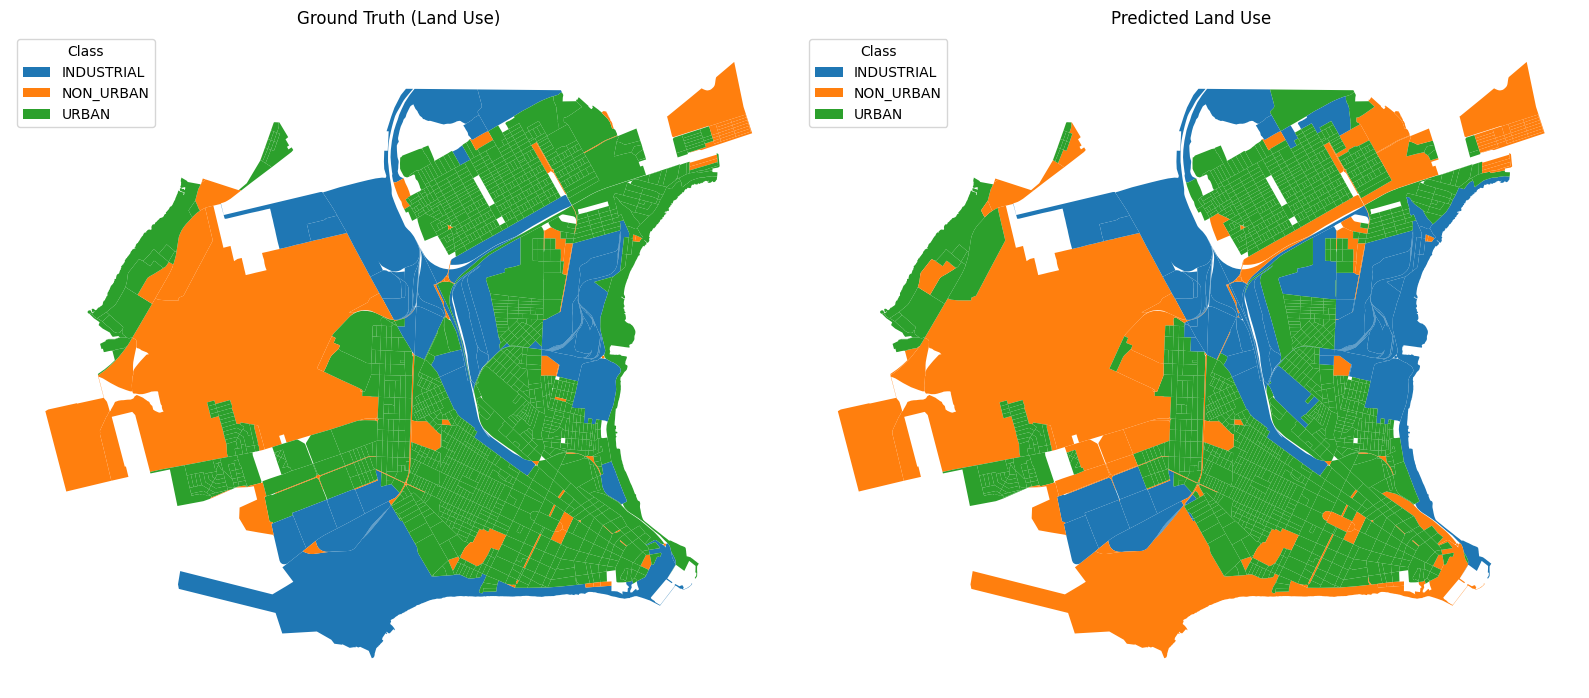

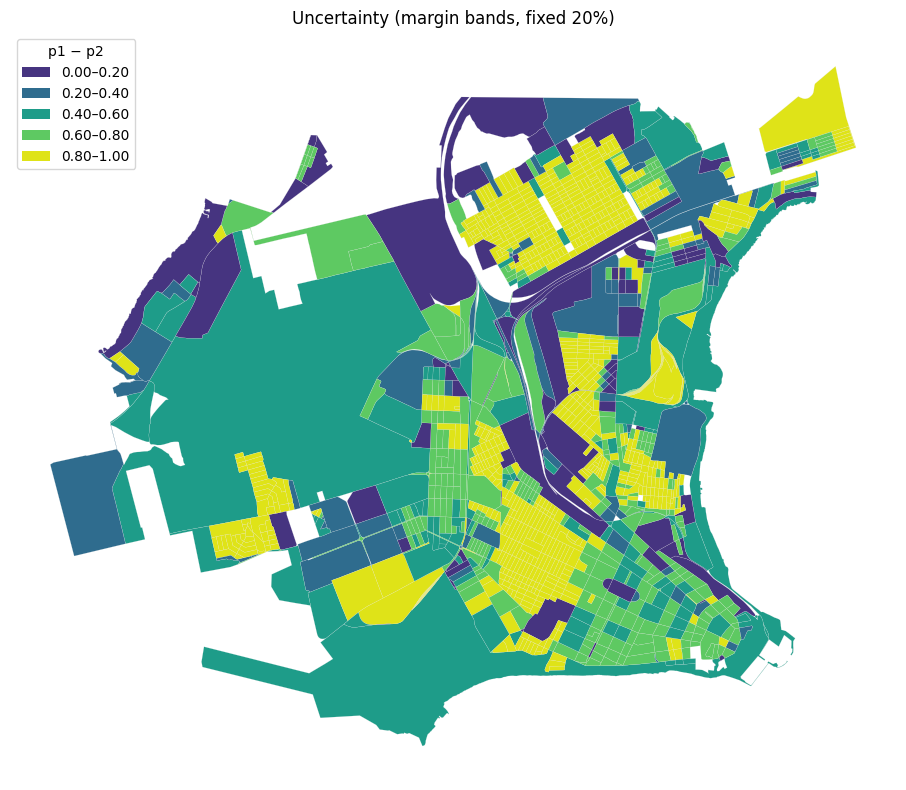

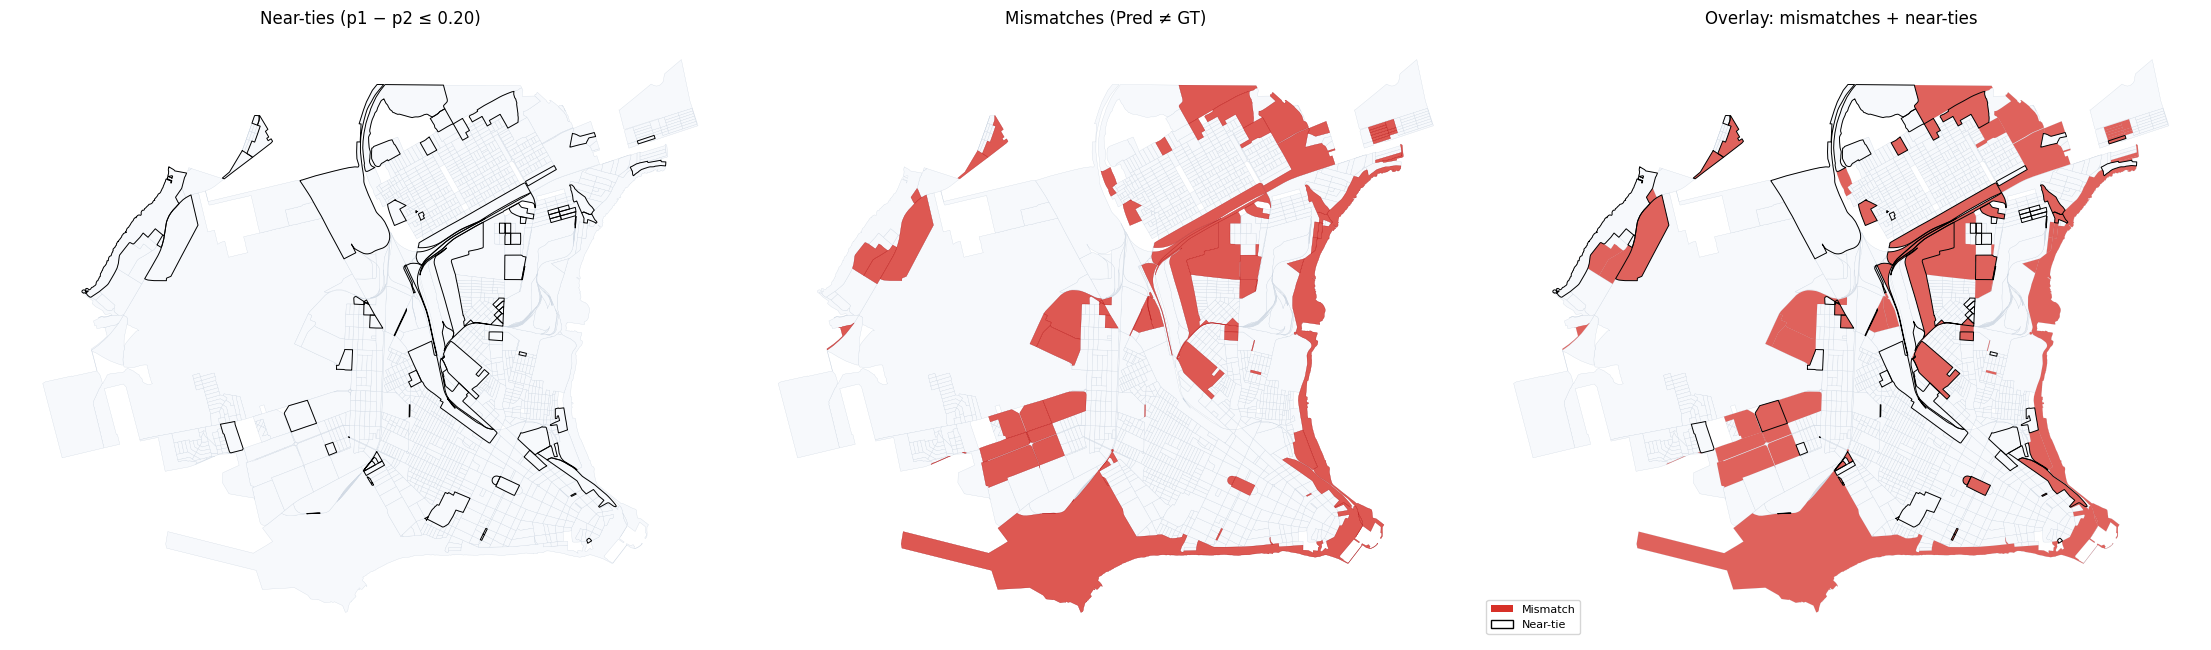

In [186]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_hex
from matplotlib.patches import Patch

# -----------------------------
# ДАННЫЕ И ПОДГОТОВКА
# -----------------------------
gdf = ft_df[ft_df.city == 'Taganrog'].copy()
prob_cols = ['INDUSTRIAL', 'NON_URBAN', 'URBAN']

def top2(row: pd.Series) -> pd.Series:
    s = row[prob_cols].astype('float32')
    s2 = s.nlargest(2)
    if s2.size < 2:
        return pd.Series({'p2': np.float32(0.0), 'c2': s2.index[0] if len(s2) else prob_cols[0]})
    return pd.Series({'p2': np.float32(s2.iloc[1]), 'c2': s2.index[1]})

gdf['pred'] = gdf[prob_cols].astype('float32').idxmax(axis=1)
gdf['p1']   = gdf[prob_cols].astype('float32').max(axis=1)
g2 = gdf.apply(top2, axis=1)
gdf = pd.concat([gdf, g2], axis=1)

gdf['margin']  = (gdf['p1'] - gdf['p2']).astype('float32')
gdf['correct'] = (gdf['pred'] == gdf['land_use'])

# фиксируем порядок классов для стабильной легенды
class_order = prob_cols
for col in ['land_use', 'pred']:
    gdf[col] = pd.Categorical(gdf[col], categories=class_order, ordered=True)

# -----------------------------
# ПРАВИЛО ЗАМЕНЫ КВАРТАЛА
# -----------------------------
TAU = 0.20
gdf['near_tie'] = gdf['margin'] <= TAU

# -----------------------------
# (1–2) GT и Pred — одна фигура
# -----------------------------
cat_colors = list(plt.cm.tab10.colors[:len(class_order)])
cat_cmap   = ListedColormap(cat_colors)
cat_legend = [Patch(facecolor=cat_colors[i], edgecolor='none', label=class_order[i])
              for i in range(len(class_order))]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
gdf.plot(column='land_use', ax=axes[0], categorical=True, cmap=cat_cmap, legend=False)
axes[0].set_title('Ground Truth (Land Use)')
axes[0].set_axis_off()
axes[0].legend(handles=cat_legend, title='Class', loc='upper left', frameon=True)

gdf.plot(column='pred', ax=axes[1], categorical=True, cmap=cat_cmap, legend=False)
axes[1].set_title('Predicted Land Use')
axes[1].set_axis_off()
axes[1].legend(handles=cat_legend, title='Class', loc='upper left', frameon=True)

plt.tight_layout()
plt.savefig('fig_1_2_gt_pred.png', dpi=300)

# -----------------------------
# (3) Uncertainty: фиксированные 20%-интервалы
# -----------------------------
bins   = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], dtype=float)
labels = ['0.00–0.20', '0.20–0.40', '0.40–0.60', '0.60–0.80', '0.80–1.00']

m_clip = np.clip(gdf['margin'].to_numpy(), 0.0, 1.0)
gdf['margin_band'] = pd.Categorical(
    pd.cut(m_clip, bins=bins, labels=labels, include_lowest=True, right=True),
    categories=labels, ordered=True
)

# ВАЖНО: цвета делаем hashable (hex), иначе .map падает
band_colors = [to_hex(c) for c in plt.cm.viridis(np.linspace(0.15, 0.95, len(labels)))]
band_map    = dict(zip(labels, band_colors))
band_legend = [Patch(facecolor=band_map[l], edgecolor='none', label=l) for l in labels]

fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax,
         color=gdf['margin_band'].map(band_map),
         edgecolor='#e6e6e6', linewidth=0.1)
ax.set_title('Uncertainty (margin bands, fixed 20%)')
ax.set_axis_off()
ax.legend(handles=band_legend, title='p1 − p2', loc='upper left', frameon=True)
plt.tight_layout()
plt.savefig('fig_3_margin_fixed_bins.png', dpi=300)

# -----------------------------
# (4–5–6) ЕДИНАЯ ПОДЛОЖКА + три панели:
# 4) near_tie, 5) mismatches, 6) overlay (4 + 5)
# -----------------------------
def draw_base(ax, gdf_):
    """Единая светлая подложка для всех трёх панелей."""
    gdf_.plot(ax=ax, color='#f7f9fc', edgecolor='#cbd5e1', linewidth=0.2, alpha=1.0)

wrong = gdf[~gdf['correct']]
amb   = gdf[gdf['near_tie']]

fig, axes = plt.subplots(1, 3, figsize=(22, 8), constrained_layout=True)

# 4) near_tie
draw_base(axes[0], gdf)
if not amb.empty:
    amb.plot(ax=axes[0], facecolor='none', edgecolor='black', linewidth=0.7)
axes[0].set_title('Near-ties (p1 − p2 ≤ 0.20)')
axes[0].set_axis_off()

# 5) mismatches
draw_base(axes[1], gdf)
if not wrong.empty:
    wrong.plot(ax=axes[1], color='#d73027', edgecolor='#b30000', linewidth=0.2, alpha=0.8)
axes[1].set_title('Mismatches (Pred ≠ GT)')
axes[1].set_axis_off()

# 6) overlay: near_tie + mismatches
draw_base(axes[2], gdf)
if not wrong.empty:
    wrong.plot(ax=axes[2], color='#d73027', edgecolor='none', alpha=0.75, label='Mismatch')
if not amb.empty:
    amb.plot(ax=axes[2], facecolor='none', edgecolor='black', linewidth=0.7, label='Near-tie')
axes[2].set_title('Overlay: mismatches + near-ties')
axes[2].set_axis_off()

handles = []
if not wrong.empty:
    handles.append(Patch(facecolor='#d73027', edgecolor='none', label='Mismatch'))
if not amb.empty:
    handles.append(Patch(facecolor='none', edgecolor='black', label='Near-tie'))
if handles:
    axes[2].legend(handles=handles, loc='lower left', frameon=True, fontsize=8)

plt.savefig('fig_4_5_6_neartie_mismatch_overlay.png', dpi=300)
